# Demo - Level 1 Algorithm

This notebook provides a simple demo of the basic filling algorithm. We start off by loading all the libraries that we will need for our demo. 

In [1]:
import numpy as np
import rasterio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from affine import Affine
from copy import copy

%matplotlib inline

# load level 1 popfill module
import popfill.loader
import popfill.kernel

  Here we specify the path for the example data, which includes a subset of WorldPop population data for an area of Indonesia. 

In [2]:
# small subset
#mask_file = "data/mask_clip_simple.tif"
#population_file = "data/pop_clip_simple.tif"

# large subset
mask_file = "data/mask_clip.tif"
population_file = "data/pop_clip.tif"

Define some functions 

In [18]:
def plot_mask(x,y,data):
    """plot the mask data"""
    # define color map for mask plotting
    mask_color = mpl.colors.ListedColormap(['beige'])
    mask_color.set_bad(color='lightblue')
    
    plt.figure(figsize=(9,6))
    plt.imshow(data,interpolation='none',cmap=mask_color,extent=[x[0,0],x[-1,-1],y[-1,-1],y[0,0]])
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

    
def plot_pop(x,y,data):
    """plot the pop data"""
    # define color map for pop plotting
    pop_color = copy(plt.cm.OrRd)
    pop_color.set_bad(color='lightblue')

    plt.figure(figsize=(9,6))
    plt.imshow(data,interpolation='none',cmap=pop_color,extent=[x[0,0],x[-1,-1],y[-1,-1],y[0,0]])
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    c_max = np.nanmax(data)
    plt.clim(0, (2/3)*c_max)
    plt.colorbar()

    
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

## Load example data and access basic info

In [4]:
loader = popfill.loader.PopulationLoader()
mask, population = loader.load(mask_file, population_file)

Get the latitude and longitude information

In [5]:
T0 = mask.profile['transform']
T1 = T0*Affine.translation(0.5, 0.5) # Get affine transform for pixel centers

# Function to convert pixel row/column index (from 0) to easting/northing at center
rc2xy = lambda r, c: (c, r) * T1

col = np.arange(mask.data.shape[1])
row = np.arange(mask.data.shape[0])
cols, rows = np.meshgrid(col, row)
x, y = rc2xy(rows, cols)  # x, y are longitude and latitude coordinates, respectively

Set different categories for pixel pairs

In [6]:
# categorize mask data
mask_re = mask.data.astype(np.int)
mask_re[mask.data==1] = 2; # land
mask_re[mask.data==0] = 1; # sea

# categorize population data
pop_re = population.data.astype(np.int)
pop_re[~np.isnan(population.data)] = 20; # data
pop_re[np.isnan(population.data)] = 10; # no data

# generate 4 different types of pixel pair
class_re = pop_re + mask_re

## Initial inspection of input data

Let's look at the mask first

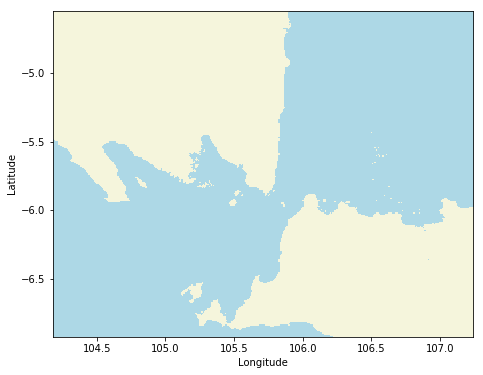

In [7]:
plt_data = np.ma.masked_where(mask.data == False, mask.data)
plot_mask(x,y,plt_data)

How about the population data?

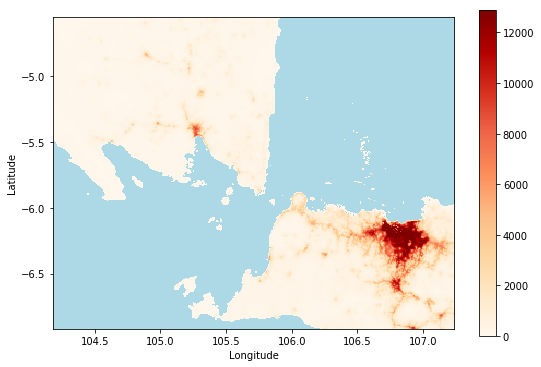

In [11]:
plt_data = np.ma.masked_where(population.data == np.nan, population.data)
plot_pop(x,y,plt_data)

What's the issue with mapping? At first glance these maps looks to have the same coverage. But let's take a look at the pixel pairs between population data and mask:

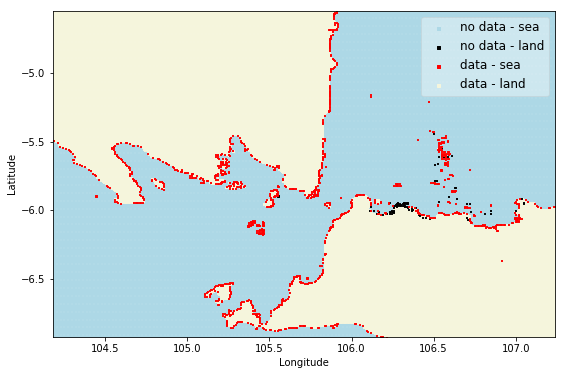

In [12]:
plt.figure(figsize=(9,6))
h1 = plt.scatter(x[class_re==11], y[class_re==11], 1, c = 'lightblue', marker = u's')
h4 = plt.scatter(x[class_re==22], y[class_re==22], 1, c = 'beige', marker = u's')
h2 = plt.scatter(x[class_re==12], y[class_re==12], 1, c = 'black', marker = u's')
h3 = plt.scatter(x[class_re==21], y[class_re==21], 1, c = 'red', marker = u's')

plt.legend((h1,h2,h3,h4),('no data - sea','no data - land','data - sea','data - land'),
           fontsize='large',markerscale=3,fancybox=True,framealpha=0.4,loc=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.xlim(x[0,0],x[-1,-1])
plt.ylim(y[-1,-1],y[0,0]);

How are this 4 different situations distributed in the dataset?

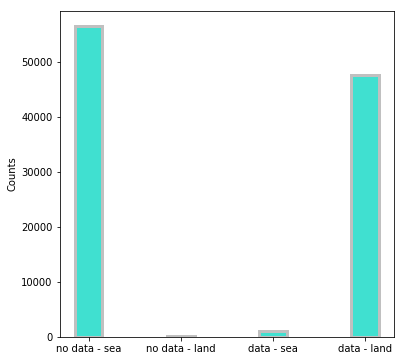

In [13]:
unique, counts = np.unique(class_re, return_counts=True)

# bar plot to show the counts of different pixel pairs
plt.figure(figsize=(6,6))

plt.ylabel('Counts')
plt.bar(np.arange(4),counts,.3,align='center',color='turquoise',edgecolor='silver',linewidth=3)
plt.xticks(np.arange(4), ('no data - sea','no data - land','data - sea','data - land'));


## Redistribute the population to mask setting

Below, the filler function applies a simple redistribution where data - sea pixels are uniformly redistributed to no data - land pixels

In [14]:
filler = popfill.kernel.Basic(mask.data, population.data)
filled_pop = filler.fill()

How does the new population data look like?

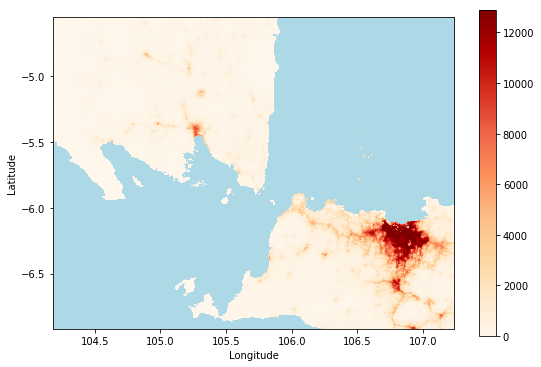

In [15]:
plt_data = np.ma.masked_where(filled_pop == np.nan, filled_pop)
plot_pop(x,y,plt_data)

## Examining the Difference 

In [16]:
# get the index reference for problematic pixel pairs

old_pop = population.data.copy()
old_pop[rows[class_re==12], cols[class_re==12]] = 0 # black points

new_pop = filled_pop.copy()
new_pop[rows[class_re==21], cols[class_re==21]] = 0 # red points

# compute the difference
pop_diff = new_pop - old_pop

Plot the difference between new and old population data

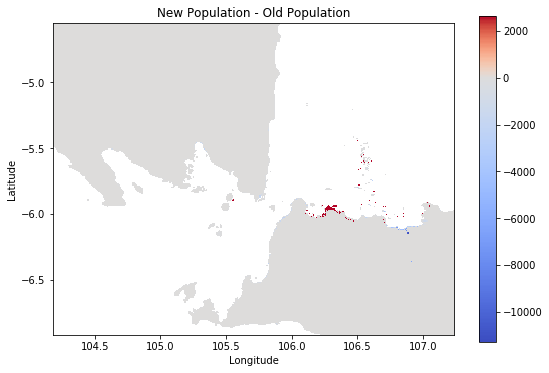

In [19]:
plt.figure(figsize=(9,6))
plt.imshow(pop_diff,interpolation='none',cmap='coolwarm',
           extent=[x[0,0],x[-1,-1],y[-1,-1],y[0,0]],
           norm=MidpointNormalize(midpoint=0.,vmin=np.nanmin(pop_diff), vmax=np.nanmax(pop_diff)))

plt.colorbar()
plt.title('New Population - Old Population')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

We cna also check that we have the same total in both the old and new pop array: this is integral, as for counts data we must preserve the sum over a given dataset or area.

In [20]:
print(np.nansum(old_pop))
print(np.nansum(new_pop))

41639844.0
41639840.0


Note that there is a slight difference (4 people, or 0.00001%) likely due to rounding of float values that were moved around.

# Export new array as raster

Finally, export the new numpy population array as a geotidff with the attributes of the original raster

In [21]:
def export_tif(array, out_path, profile):
    '''
    array: input fixed numpy array
    out_path: out path for raster (.tif format)
    profile: dictonary defining raster attributes
    '''
    
    #open, define, export array to tiff
    with rasterio.open(out_path, 'w', **profile) as out_rast:
        out_rast.write(array, 1)
        
out_prof = mask.profile
out_path = "data/pop_out_clip.tif"

export_tif(filled_pop, out_path, out_prof)

We can check the mask and new population have the exact same attributes

In [22]:
new_pop_tif = rasterio.open(out_path)

print(new_pop_tif.profile)
print(mask.profile)
new_pop_tif.close()

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 368, 'height': 286, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.008333333333333014, 0.0, 104.17499999998864,
       0.0, -0.008333333333333, -4.541666666662891), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 368, 'height': 286, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.008333333333333014, 0.0, 104.17499999998864,
       0.0, -0.008333333333333, -4.541666666662891), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
